<a href="https://www.kaggle.com/code/joshuacurtiswebb/simuledge?scriptVersionId=141477800" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
from spx_strategies import *

#########################
# VERSION
#########################
notebook_name = 'simuledge'
notebook_v=0

#########################
# DATA CONFIGURATION
#########################
load_cboe = False
load_tradier = True

#########################
# STUDY CONFIGURATION
#########################
op_sel = DeltaOptionSelector
ent_pol_study = OptionSelectorStaticEntryPolicy
ex_pol_study = HoldToExpStaticExitPolicy
study_param_ranges = {
    'sp':(0.005,0.45),
    'lp':(0.002,''),
    'sc':(0.005,0.45),
    'lc':(0.002,''),
}

misc_configs_ent_pol = {    
    'dte':1,
    'pt':'16:00:00'}

misc_configs_ex_pol ={
}

misc_configs_strat ={
    'comm':1.5,
    'ipv': 0.2
}
misc_configs_strat['ds'] = 'tradier' if load_tradier else 'cboe'
# IPV will be overwritten when data is loaded
initial_portfolio_value = 1





In [2]:
import logging
import sys
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta, time
import matplotlib.pyplot as plt
from time import perf_counter
import optuna
import os
from shutil import copy
from textwrap import wrap
pd.set_option("max_columns", 200)

#copy db
cwd = os.getcwd()
output_spx_spread_backtester_path = '/kaggle/input/simuledge/'
dir_list = os.listdir(output_spx_spread_backtester_path)
files = [f for f in dir_list if os.path.isfile(output_spx_spread_backtester_path+f) and ".db" in f] #Filtering only the db files.
for f in files:
    if not os.path.exists(cwd+'/'+f):
        print(f"Copying db file to output : {f}")
        copy(output_spx_spread_backtester_path+f,cwd+'/'+f)


Copying db file to output : optimal-short-ic-study_2023-2023_1DTE_2023-08-26-22.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-07-31-20.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-13-22.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-14-22.db
Copying db file to output : optimal-short-ic-study_2023-2023_1DTE_2023-08-23-22.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-01-15.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-17-22.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-12-22.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-08-23.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-18-22.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-22-22.db
Copying db file to output : optim

In [3]:
def ipv_transform(df, scaling_factor):
    if 'price' not in df.columns:
        raise Exception("Need 'price' in dataframe")
        
    return df.loc[1,'price']*scaling_factor*100


In [4]:
if load_cboe:

    files = [
    #     f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2020_0dte_all.csv", 
    #     f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2021_0dte_all.csv", 
    #    f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2022_0dte_all.csv"
        #f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2021_1545_1600.csv",
       # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2020_1545_1600.csv"
       # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2022_1545_1600.csv"
     #  f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2019_1545_1600.csv"
      #  f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2018_1545_1600.csv"
       # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2017_1545_1600.csv"
      # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2016_1545_1600.csv"
       f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2019_1dte_all.csv",
        f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2020_1dte_all.csv",
        f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2021_1dte_all.csv",
        f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2022_1dte_all.csv"
    ]
    li = []
    for f in files:   
        df = pd.read_csv(f, index_col=None, header=0, dtype={'type':'category','quote_time':'category'})
        li.append(df)

    df = pd.concat(li, axis=0, ignore_index=True)
    df['expiration']=pd.to_datetime(df['expiration'],infer_datetime_format=True)
    df['quote_date']=pd.to_datetime(df['quote_date'],infer_datetime_format=True)
    df['delta'] = df['delta'].abs()

    if 'dte' not in df:
        raise Exception("dte must be present")

    df_ty = pd.read_csv(f"/kaggle/input/treasury-yield-13w-2012-2022/13_week_treasury_yield.csv", index_col=None, header=0)
    df_ty['Date'] = pd.to_datetime(df_ty['Date'])
    
    df_irx = df_ty

In [5]:
if load_tradier:
    for dirname, _, filenames in os.walk('/kaggle/input/spx-option-chain-1dte-all-times'):
        for f in filenames:
            if 'spx' in f:
                df = pd.read_csv(os.path.join(dirname, f), index_col=None, header=0)
                df.rename(columns={'underlying':'price'},inplace=True)
                df.drop(columns=['Unnamed: 0'], inplace=True)
                df['expiration']=pd.to_datetime(df['expiration'],infer_datetime_format=True)
                df['quote_date']=pd.to_datetime(df['quote_date'],infer_datetime_format=True)
                df['delta'] = df['delta'].abs()
            elif 'irx' in f:
                df_irx = pd.read_csv(os.path.join(dirname, f), index_col=None, header=0)
                df_irx.rename(columns={'close':'Adj Close','quote_date':'Date'},inplace=True)
                df_irx['Adj Close']*= 100
                df_irx['Date']=pd.to_datetime(df_irx['Date'],infer_datetime_format=True)
                df_irx['quote_time']=pd.to_datetime(df_irx['quote_time'],infer_datetime_format=True)
                df_irx = df_irx.loc[df_irx.groupby('Date')['quote_time'].idxmax()]
                df_irx.drop(columns=['Unnamed: 0', 'quote_time'], inplace=True)


In [6]:
# For whatever data we've loaded, create an initial portfolio value
initial_portfolio_value = ipv_transform(df, misc_configs_strat['ipv'])

# Backtest Optimization

In [7]:
# purchase_time = '16:01:00'
# dos = DeltaOptionSelector(short_puts=0.04, short_calls=0.02)
# # dos = YieldOptionSelector(short_puts=0.0006, short_calls=0.0003, ipv=initial_portfolio_value)
# ent_pol=OptionSelectorStaticEntryPolicy(1, purchase_time, dos)
# #ex_pol = HoldToExpStaticExitPolicy('16:00:00')
# ex_pol = MaxLossDynamicExitPolicy(1.5)
# strat = StaticEntryDynamicExitStrategy(commission, df_irx, initial_portfolio_value, ent_pol, ex_pol, debug=True)
# strat.evaluate(df)


In [8]:
def run_backtest(strat, df):
    return strat.evaluate(df)['Cumulative Return']

In [9]:
def objective(trial, df, purchase_time):
    delta_sp_trial = trial.suggest_float(list(study_param_ranges.keys())[0], list(study_param_ranges.values())[0][0], list(study_param_ranges.values())[0][1])
    delta_lp_trial = trial.suggest_float(list(study_param_ranges.keys())[1], list(study_param_ranges.values())[1][0], delta_sp_trial)
    delta_sc_trial = trial.suggest_float(list(study_param_ranges.keys())[2], list(study_param_ranges.values())[2][0], list(study_param_ranges.values())[2][1])
    delta_lc_trial = trial.suggest_float(list(study_param_ranges.keys())[3], list(study_param_ranges.values())[3][0], delta_sc_trial)
   
    dos = op_sel(short_puts=delta_sp_trial, long_puts=delta_lp_trial,short_calls=delta_sc_trial, long_calls=delta_lc_trial)
    ent_pol=ent_pol_study(misc_configs_ent_pol['dte'], misc_configs_ent_pol['pt'], dos)
    
    ex_pol = ex_pol_study()

    strategy = StaticEntryStaticExitStrategy(misc_configs_strat['comm'], df_irx, initial_portfolio_value, ent_pol, ex_pol, debug=False)
    score = run_backtest(strategy, df)
    return score

In [10]:
# The following code builds the fully described study, including entry and exit policy, data, trial search params, etc

new_study_name = op_sel.__name__ + '_' + ent_pol_study.__name__

# concatenate ranges first
for k,v in study_param_ranges.items():
    new_study_name+="_"+k+"_"+str(v[0])+"_"+str(v[1])
    
# concatenate static values second
for k,v in misc_configs_ent_pol.items():
    new_study_name += f"_{k}_{v}"
        
new_study_name += f"_{ex_pol_study.__name__}"
        
for k,v in misc_configs_ex_pol.items():
    new_study_name += f"_{k}_{v}"
        
for k,v in misc_configs_strat.items():
    new_study_name += f"_{k}_{v}"
            
new_study_name += df['quote_date'].min().date().strftime("%y%m%d") +'_' + df['quote_date'].max().date().strftime("%y%m%d")

new_study_name += "_spx_st_" + str(spx_strat_v)

new_study_name += "_" + notebook_name + "_" + str(notebook_v)
    
new_study_name = study_name_reducer(new_study_name)

In [11]:

study_name = new_study_name  # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(direction = "maximize", study_name=study_name, storage=storage_name, load_if_exists=True)
study.optimize(lambda trial: objective(trial, df, misc_configs_ent_pol['pt']), n_trials = 10)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

[I 2023-08-30 17:12:18,041] A new study created in RDB with name: DOS_OSSEntryP_sp_0.005_0.45_lp_0.002__sc_0.005_0.45_lc_0.002__dte_1_pt_16:00:00_HTESExitP_comm_1.5_ipv_0.2_ds_tradier230714_230829_spx_st_0_simuledge_0
[I 2023-08-30 17:12:26,067] Trial 0 finished with value: -0.149 and parameters: {'sp': 0.38584648201352234, 'lp': 0.2291538548773891, 'sc': 0.2764188934256338, 'lc': 0.2054036735789205}. Best is trial 0 with value: -0.149.
[I 2023-08-30 17:12:33,814] Trial 1 finished with value: 1.343 and parameters: {'sp': 0.3669724824973117, 'lp': 0.09590581154360028, 'sc': 0.2535783039050546, 'lc': 0.14231774275761455}. Best is trial 1 with value: 1.343.
[I 2023-08-30 17:12:41,525] Trial 2 finished with value: 0.449 and parameters: {'sp': 0.2148075375774131, 'lp': 0.16692684022553983, 'sc': 0.39545639212595834, 'lc': 0.03658195995963616}. Best is trial 1 with value: 1.343.
[I 2023-08-30 17:12:49,247] Trial 3 finished with value: -2.218 and parameters: {'sp': 0.42934779299750564, 'lp': 

Best Score:  3.613
Best Params: 
  lc: 0.2926883256272648
  lp: 0.20440472358852219
  sc: 0.3707085457718415
  sp: 0.36488280852119004


# Backtest with current best score

*****  BACKTEST RESULTS  ****
Cumulative Return                                 3.613
Max Drawdown                                     -0.815
Mean Net Max Loss                              1118.281
Max Net Max Loss                                 1782.5
Mean Return on Max Risk                           0.062
Std Dev of Return on Max Risk                     0.821
Risk Adj Cumulative Return On Scaled Max Risk     4.401
Trading Days                                         32
Wins                                                 18
Losses                                               14
Breakeven                                             0
Win/Loss Ratio                                    56.25
Mean Win                                          403.0
Mean Loss                                      -546.929
Mean Net Trans                                  -12.594
Std Dev of Net Trans                            668.613
Max Loss                                        -1736.0
Max Win           

,trade_date,expiration,trade_count,delta_sp_target_0,strike_sp_0,delta_sp_0,collected_sp_0,delta_sc_target_0,strike_sc_0,delta_sc_0,collected_sc_0,delta_lc_target_0,strike_lc_0,delta_lc_0,collected_lc_0,delta_lp_target_0,strike_lp_0,delta_lp_0,collected_lp_0,collected,lost_c,lost_p,price,commission,lost,net,portfolio_value,net_cumsum,transaction_return,cum_return,daily_risk_free_return,gross_max_loss,net_max_loss,return_on_max_risk,scaled_return_on_max_risk
0,2023-07-14,2023-07-17,4.0,0.364883,4495.0,0.355303,635.0,0.370709,4515.0,0.346514,600.0,0.292688,4520.0,0.278566,-447.5,0.204405,4480.0,0.178156,-262.5,525.0,500.0,0.0,4526.69,6.0,500.0,19.0,90219.8,19.0,NaN,0.000211,0.000207,1500.0,975.0,0.019487,1.000390
1,2023-07-17,2023-07-18,4.0,0.364883,4515.0,0.333631,640.0,0.370709,4535.0,0.351153,467.5,0.292688,4540.0,0.270383,-340.0,0.204405,4500.0,0.165757,-250.0,517.5,500.0,0.0,4558.32,6.0,500.0,11.5,90231.3,30.5,0.000127,0.000338,0.000208,1500.0,982.5,0.011705,1.000234
2,2023-07-18,2023-07-19,4.0,0.364883,4545.0,0.304246,535.0,0.370709,4570.0,0.313604,452.5,0.292688,4575.0,0.243652,-330.0,0.204405,4535.0,0.192177,-295.0,362.5,0.0,0.0,4568.48,6.0,0.0,356.5,90587.8,387.0,0.003951,0.004290,0.000208,1000.0,637.5,0.559216,1.011184
3,2023-07-19,2023-07-20,4.0,0.364883,4555.0,0.311034,577.5,0.370709,4580.0,0.357224,710.0,0.292688,4585.0,0.288878,-512.5,0.204405,4540.0,0.166846,-270.0,505.0,0.0,1500.0,4534.01,6.0,1500.0,-1001.0,89586.8,-614.0,-0.011050,-0.006807,0.000208,1500.0,995.0,-1.006030,0.979879
4,2023-07-20,2023-07-21,4.0,0.364883,4525.0,0.353625,625.0,0.370709,4545.0,0.369584,775.0,0.292688,4555.0,0.243667,-415.0,0.204405,4520.0,0.203510,-207.5,777.5,0.0,0.0,4537.79,6.0,0.0,771.5,90358.3,157.5,0.008612,0.001746,0.000208,1000.0,222.5,3.467416,1.069348
5,2023-07-21,2023-07-24,4.0,0.364883,4525.0,0.304814,567.5,0.370709,4550.0,0.335813,527.5,0.292688,4555.0,0.256297,-355.0,0.204405,4515.0,0.203527,-345.0,395.0,282.0,0.0,4552.82,6.0,282.0,107.0,90465.3,264.5,0.001184,0.002932,0.000208,1000.0,605.0,0.176860,1.003537
6,2023-07-24,2023-07-25,4.0,0.364883,4545.0,0.353496,545.0,0.370709,4565.0,0.333312,577.5,0.292688,4570.0,0.266444,-425.0,0.204405,4530.0,0.169521,-225.0,472.5,500.0,0.0,4571.38,6.0,500.0,-33.5,90431.8,231.0,-0.000370,0.002561,0.000208,1500.0,1027.5,-0.032603,0.999348
7,2023-07-25,2023-07-26,4.0,0.364883,4555.0,0.361185,1210.0,0.370709,4590.0,0.337122,935.0,0.292688,4600.0,0.252709,-625.0,0.204405,4530.0,0.187364,-495.0,1025.0,0.0,0.0,4566.59,6.0,0.0,1019.0,91450.8,1250.0,0.011268,0.013858,0.000209,2500.0,1475.0,0.690847,1.013817
8,2023-07-26,2023-07-27,4.0,0.364883,4555.0,0.315993,527.5,0.370709,4580.0,0.339728,685.0,0.292688,4585.0,0.281866,-532.5,0.204405,4540.0,0.167403,-257.5,422.5,0.0,1500.0,4533.77,6.0,1500.0,-1083.5,90367.3,166.5,-0.011848,0.001846,0.000209,1500.0,1077.5,-1.005568,0.979889
9,2023-07-27,2023-07-28,4.0,0.364883,4520.0,0.347490,875.0,0.370709,4550.0,0.355416,990.0,0.292688,4560.0,0.267386,-660.0,0.204405,4500.0,0.201046,-472.5,732.5,1000.0,0.0,4578.72,6.0,1000.0,-273.5,90093.8,-107.0,-0.003027,-0.001186,0.000209,2000.0,1267.5,-0.215779,0.995684


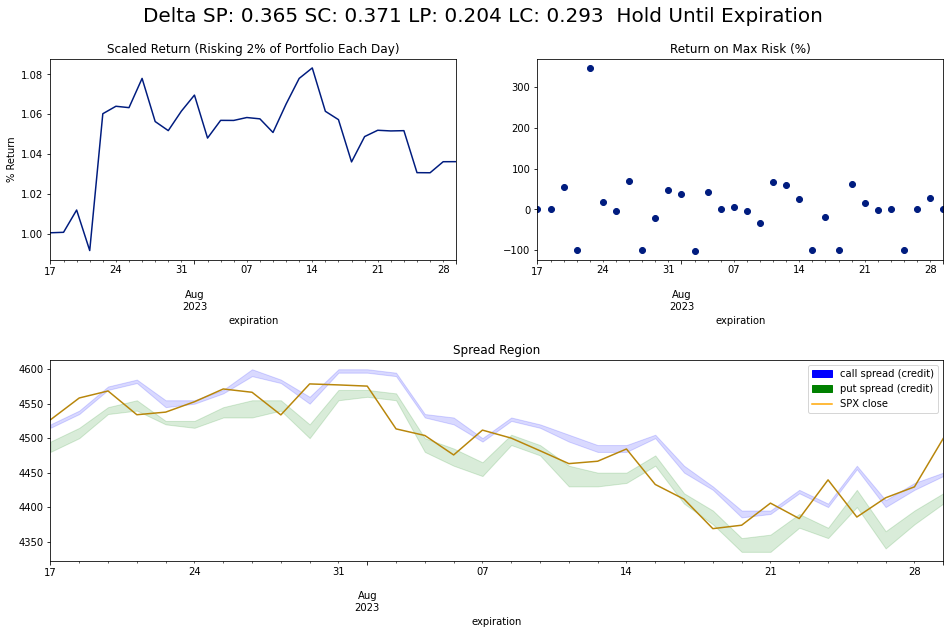

In [12]:
dos = DeltaOptionSelector(short_puts=trial.params['sp'],short_calls=trial.params['sc'], long_puts=trial.params['lp'],long_calls=trial.params['lc'])
ent_pol=OptionSelectorStaticEntryPolicy(1, misc_configs_ent_pol['pt'], dos)
ex_pol = HoldToExpStaticExitPolicy()
strat = StaticEntryStaticExitStrategy(misc_configs_strat['comm'], df_irx, initial_portfolio_value, ent_pol, ex_pol, debug=True)
strat.evaluate(df)

strat.df_trades

*****  BACKTEST RESULTS  ****
Cumulative Return                                -3.605
Max Drawdown                                     -3.605
Mean Win Trans Return                               1.1
Mean Loss Trans Return                           -1.991
Mean Trans Return                                -0.097
Std Dev of Trans Return                           0.019
Sharpe Ratio static STD                          -0.994
Sharpe Ratio with RF STD                         -0.994
Risk Adj Cumulative Return                     -191.696
Dampened Risk Adj Cumulative Return             -26.287
Trading Days                                         32
Wins                                                 19
Losses                                               13
Breakeven                                             0
Win/Loss Ratio                                   59.375
Mean Win                                          996.5
Mean Loss                                     -1706.538
Mean Net Trans    

,trade_date,expiration,trade_count,yield_sp_target_0,strike_sp_0,delta_sp_0,collected_sp_0,yield_sc_target_0,strike_sc_0,delta_sc_0,collected_sc_0,collected,lost_c,lost_p,price,commission,lost,net,portfolio_value,net_cumsum,transaction_return,cum_return,daily_risk_free_return,short_long_balance_call,short_long_balance_put
0,2023-07-14,2023-07-17,2.0,0.01,4505.0,0.503940,1025.0,0.01,4505.0,0.496281,1030.0,2055.0,2169.0,0.0,4526.69,3.0,2169.0,-117.0,90083.8,-117.0,NaN,-0.001297,0.000207,-1.0,-1.0
1,2023-07-17,2023-07-18,2.0,0.01,4520.0,0.401656,860.0,0.01,4525.0,0.551838,850.0,1710.0,3332.0,0.0,4558.32,3.0,3332.0,-1625.0,88458.8,-1742.0,-0.018039,-0.019312,0.000208,-1.0,-1.0
2,2023-07-18,2023-07-19,2.0,0.01,4555.0,0.443344,950.0,0.01,4555.0,0.576088,1050.0,2000.0,1348.0,0.0,4568.48,3.0,1348.0,649.0,89107.8,-1093.0,0.007337,-0.012117,0.000208,-1.0,-1.0
3,2023-07-19,2023-07-20,2.0,0.01,4565.0,0.440975,940.0,0.01,4575.0,0.418772,855.0,1795.0,0.0,3099.0,4534.01,3.0,3099.0,-1307.0,87800.8,-2400.0,-0.014668,-0.026607,0.000208,-1.0,-1.0
4,2023-07-20,2023-07-21,2.0,0.01,4540.0,0.651749,860.0,0.01,4535.0,0.494829,855.0,1715.0,279.0,221.0,4537.79,3.0,500.0,1212.0,89012.8,-1188.0,0.013804,-0.013171,0.000208,-1.0,-1.0
5,2023-07-21,2023-07-24,2.0,0.01,4535.0,0.437252,1005.0,0.01,4540.0,0.496859,942.5,1947.5,1282.0,0.0,4552.82,3.0,1282.0,662.5,89675.3,-525.5,0.007443,-0.005826,0.000208,-1.0,-1.0
6,2023-07-24,2023-07-25,2.0,0.01,4555.0,0.527620,930.0,0.01,4555.0,0.479411,1035.0,1965.0,1638.0,0.0,4571.38,3.0,1638.0,324.0,89999.3,-201.5,0.003613,-0.002234,0.000208,-1.0,-1.0
7,2023-07-25,2023-07-26,2.0,0.01,4550.0,0.322377,1025.0,0.01,4590.0,0.337122,935.0,1960.0,0.0,0.0,4566.59,3.0,0.0,1957.0,91956.3,1755.5,0.021745,0.019462,0.000209,-1.0,-1.0
8,2023-07-26,2023-07-27,2.0,0.01,4565.0,0.461741,855.0,0.01,4575.0,0.403442,892.5,1747.5,0.0,3123.0,4533.77,3.0,3123.0,-1378.5,90577.8,377.0,-0.014991,0.004180,0.000209,-1.0,-1.0
9,2023-07-27,2023-07-28,2.0,0.01,4525.0,0.397876,1055.0,0.01,4550.0,0.355416,990.0,2045.0,2872.0,0.0,4578.72,3.0,2872.0,-830.0,89747.8,-453.0,-0.009163,-0.005022,0.000209,-1.0,-1.0


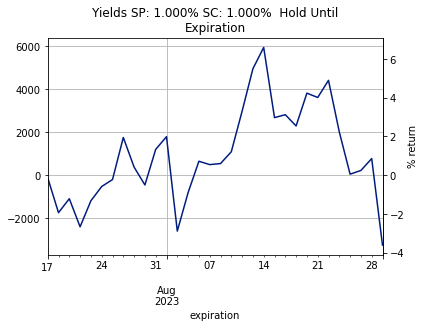

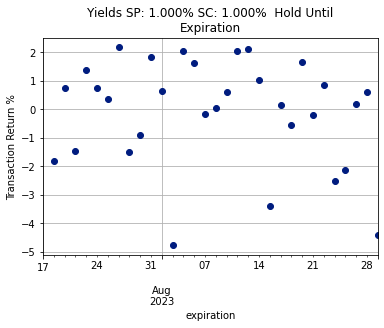

In [13]:
yos = YieldOptionSelector(short_puts=0.01, short_calls=0.01, ipv=initial_portfolio_value)
ent_pol=OptionSelectorStaticEntryPolicy(1, misc_configs_ent_pol['pt'], yos)
ex_pol = HoldToExpStaticExitPolicy()
strat = StaticEntryStaticExitStrategy(misc_configs_strat['comm'], df_irx, initial_portfolio_value, ent_pol, ex_pol, debug=True)
strat.evaluate(df)

strat.df_trades

# Strikes for tomorrow with current best

In [14]:
next_exp = df['expiration'].max()
quote_date_next_exp = df[(df['expiration']==df['expiration'].max())&(df['quote_date']!=df['expiration'].max())]['quote_date'].iloc[0]
df_trades = pd.DataFrame([{'trade_date':quote_date_next_exp,'expiration':next_exp}])
df_filt = df[
    (df['expiration']==df['expiration'].max())&
    (df['quote_date']!=df['expiration'].max())&
    (df['quote_time']=='16:00:00')
]

In [15]:
dos = DeltaOptionSelector(short_puts=trial.params['sp'],short_calls=trial.params['sc'], long_puts=trial.params['lp'],long_calls=trial.params['lc'])
ent_pol=OptionSelectorStaticEntryPolicy(1, '16:01:00', dos)
dos.populateTrades(df_filt,df_trades,ent_pol.get_contract_strike)

,trade_date,expiration,delta_sp_target_0,strike_sp_0,delta_sp_0,collected_sp_0,delta_sc_target_0,strike_sc_0,delta_sc_0,collected_sc_0,delta_lc_target_0,strike_lc_0,delta_lc_0,collected_lc_0,delta_lp_target_0,strike_lp_0,delta_lp_0,collected_lp_0,trade_count,collected
0,2023-08-29,2023-08-30,0.364883,4485.0,0.320214,690.0,0.370709,4510.0,0.369198,730.0,0.292688,4520.0,0.247499,-422.5,0.204405,4470.0,0.183239,-340.0,4,657.5


# Strikes following the 4/2 Strategy

In [16]:
dos = DeltaOptionSelector(short_puts=0.04,short_calls=0.02)
ent_pol=OptionSelectorStaticEntryPolicy(1, '16:01:00', dos)
dos.populateTrades(df_filt,df_trades,ent_pol.get_contract_strike)

,trade_date,expiration,delta_sp_target_0,strike_sp_0,delta_sp_0,collected_sp_0,delta_sc_target_0,strike_sc_0,delta_sc_0,collected_sc_0,delta_lc_target_0,strike_lc_0,delta_lc_0,collected_lc_0,delta_lp_target_0,strike_lp_0,delta_lp_0,collected_lp_0,trade_count,collected
0,2023-08-29,2023-08-30,0.04,4425.0,0.035281,57.5,0.02,4575.0,0.018023,20.0,0.292688,4520.0,0.247499,-422.5,0.204405,4470.0,0.183239,-340.0,4,-685.0
